In [ ]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [ ]:
def run_pca(dataframe,feat_cols,rndperm,
            label_axis : str,label_list,
            title=None, legendtitle=None,
            save_filename=None):
  pca = PCA(n_components=3)
  data_values = dataframe[feat_cols].values
  pca_result = pca.fit_transform(data_values)

  # Store PCA values on dataframe
  dataframe['pca-one'] = pca_result[:,0]
  dataframe['pca-two'] = pca_result[:,1] 
  dataframe['pca-three'] = pca_result[:,2]

  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
  plt.figure(figsize=(10,8))

  fig = sns.scatterplot(
      x="pca-one", y="pca-two", # Seek from the df only these two components
      hue=label_axis,
      palette=sns.color_palette("hls", len(label_list)),
      
      # .loc() Calls the dataframe indexer, in this case at rnd lcoations
      data=dataframe.loc[rndperm,:],
      legend="full",
      alpha=0.3
  )
  plt.title(title)
  if save_filename is not None:
    plt.savefig(save_filename)
  else:
    plt.show(fig)
  return

In [ ]:
def run_tsne(dataframe,feat_cols,
             rndperm, label_axis : str,
             label_list, title= None,
             legendtitle=None,
             save_filename=None):
  
  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
  
  data_values = dataframe[feat_cols].values
  tsne_results = tsne.fit_transform(data_values)

  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  dataframe['tsne-2d-one'] = tsne_results[:,0]
  dataframe['tsne-2d-two'] = tsne_results[:,1]

  plt.figure(figsize=(10,8))
  fig = sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue=label_axis,
      palette=sns.color_palette("hls", len(label_list)),
      data=dataframe.loc[rndperm,:],
      legend="full",
      alpha=0.3
  )
  plt.title(title)
  if save_filename is not None:
    plt.savefig(save_filename)
  else:
    plt.show(fig)
  return

### Load FiLM Features

In [ ]:
!tar -xf features.tar

In [ ]:
models = ['all_parallel', 'noise_parallel_transient_params', 'noise_transient_params', 'transient_params']
instruments = ['kick', 'snare', 'tom', 'hihat', 'cymbals', 'percussion', 'clap']
sampletype = ['a','e']


feature_results = {}

for model in models:
  
  # create an Empty DataFrame object
  features_df = pd.DataFrame()
  
  for i_id, instrument in enumerate(instruments):
    for s_id, stype in enumerate(sampletype):
      featfile = f'./features/{model}_percussion_{stype}_{instrument}.pt'
      X = torch.load(featfile).numpy()
      feature_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]
      df = pd.DataFrame(X,columns=feature_cols)
      df['i_id'] = (np.ones(X.shape[0])*i_id).astype(int)
      df['s_id'] = (np.ones(X.shape[0])*s_id).astype(int)
      df['sampletype'] = df['s_id'].apply(lambda i: stype)
      df['instrument'] = df['i_id'].apply(lambda i: instrument)
      features_df = pd.concat([features_df,df.copy()])
      features_df = features_df.reset_index(drop=True)
  
  feature_results[model] = features_df.copy()
  print(f'Model: {model}. Feat size: {features_df.shape}')


Model: all_parallel. Feat size: (2495, 132)
Model: noise_parallel_transient_params. Feat size: (2495, 132)
Model: noise_transient_params. Feat size: (2495, 132)
Model: transient_params. Feat size: (2495, 132)


### Create a random permutation (dataset comes sorted by label)

In [ ]:
# For reproducability of the results
np.random.seed(42)
n_samples = feature_results[models[0]].shape[0]

permutation = np.random.permutation(n_samples)
print(permutation.shape)

(2495,)


### Iterate through models and generate plots

Explained variation per principal component: [0.3629191  0.11819626 0.08328758]
Explained variation per principal component: [0.3629193  0.11819635 0.08328762]
t-SNE done! Time elapsed: 34.97207307815552 seconds
t-SNE done! Time elapsed: 30.370304584503174 seconds
Explained variation per principal component: [0.20988674 0.0866296  0.07365876]
Explained variation per principal component: [0.2098867  0.08662964 0.07365876]
t-SNE done! Time elapsed: 26.208799123764038 seconds
t-SNE done! Time elapsed: 22.59578585624695 seconds
Explained variation per principal component: [0.25494725 0.1742132  0.09736384]
Explained variation per principal component: [0.25494722 0.17421344 0.09736384]
t-SNE done! Time elapsed: 21.758803367614746 seconds
t-SNE done! Time elapsed: 21.484507083892822 seconds
Explained variation per principal component: [0.21646814 0.14870498 0.13533403]
Explained variation per principal component: [0.2164681  0.14870495 0.13533387]
t-SNE done! Time elapsed: 24.59263277053833 

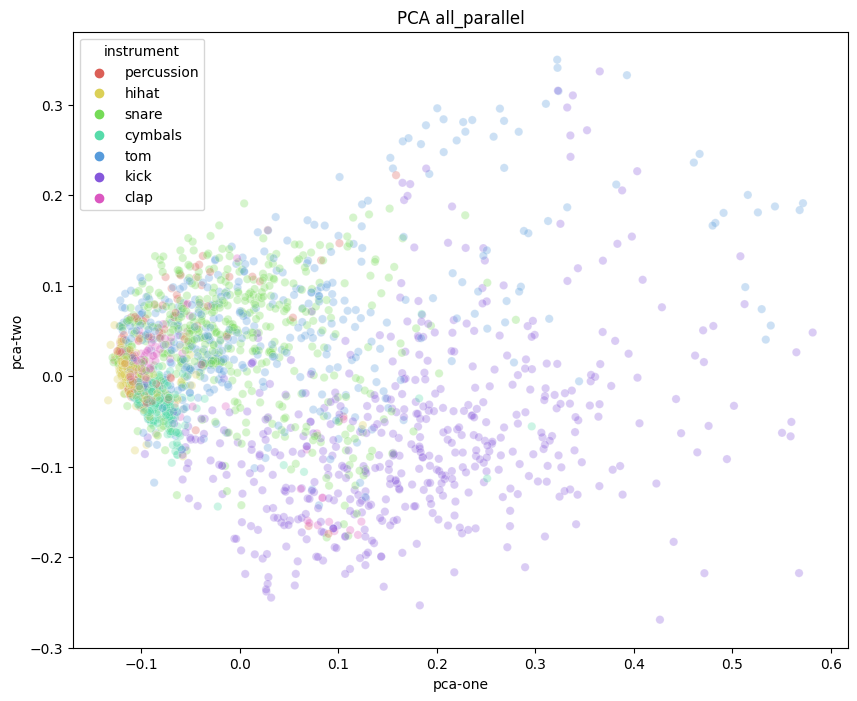

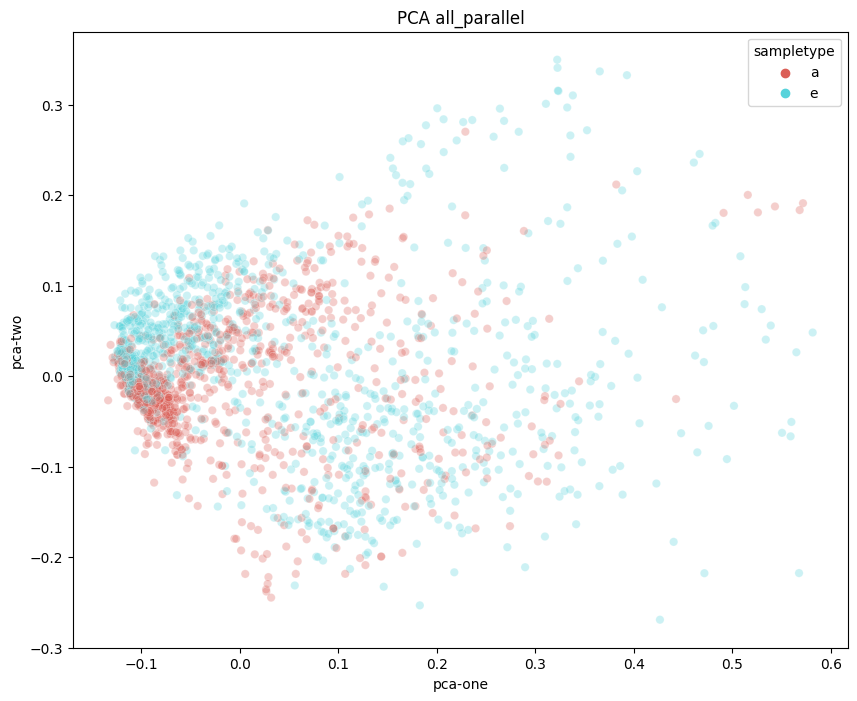

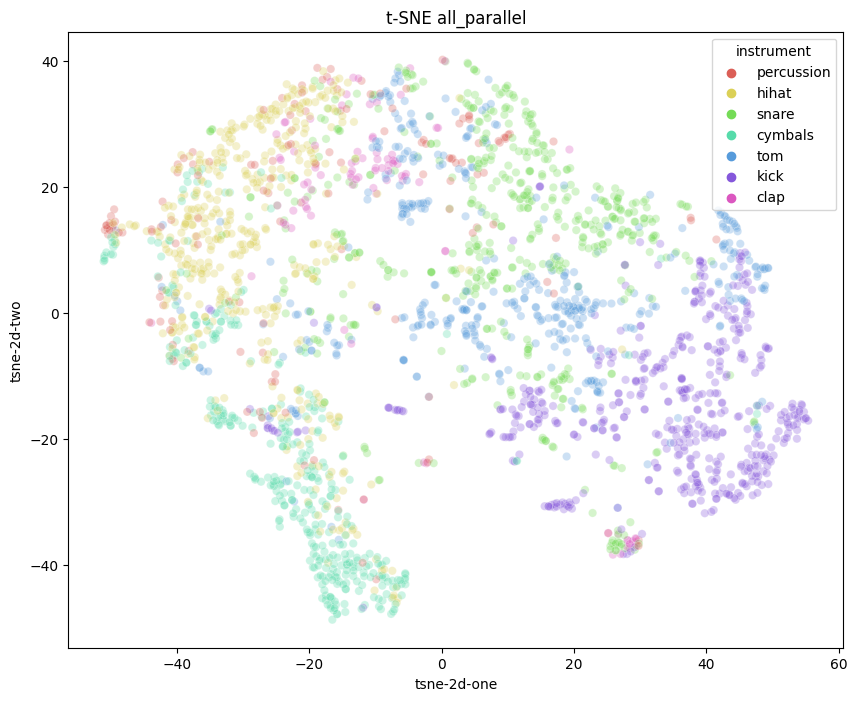

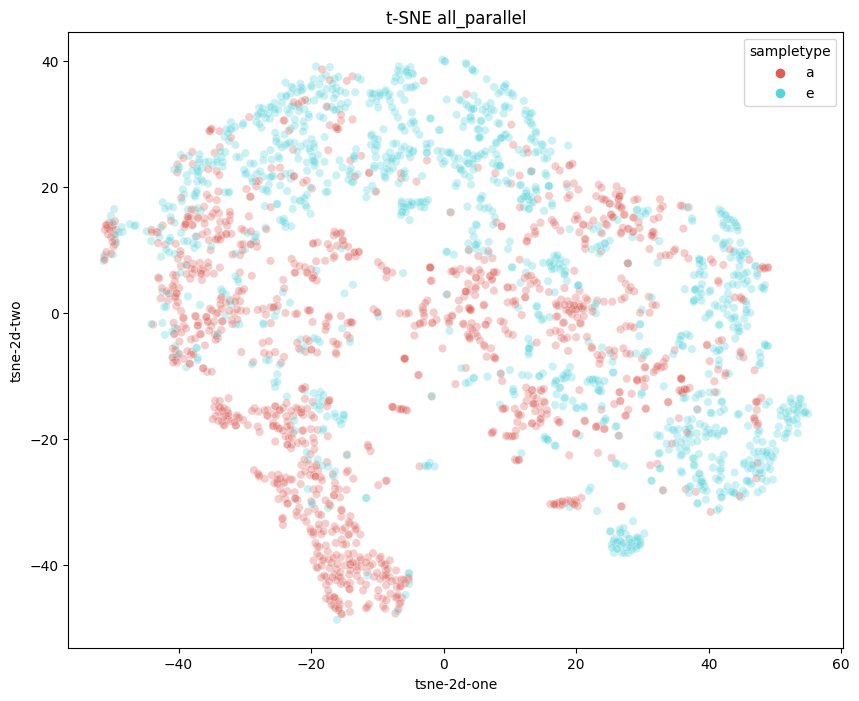

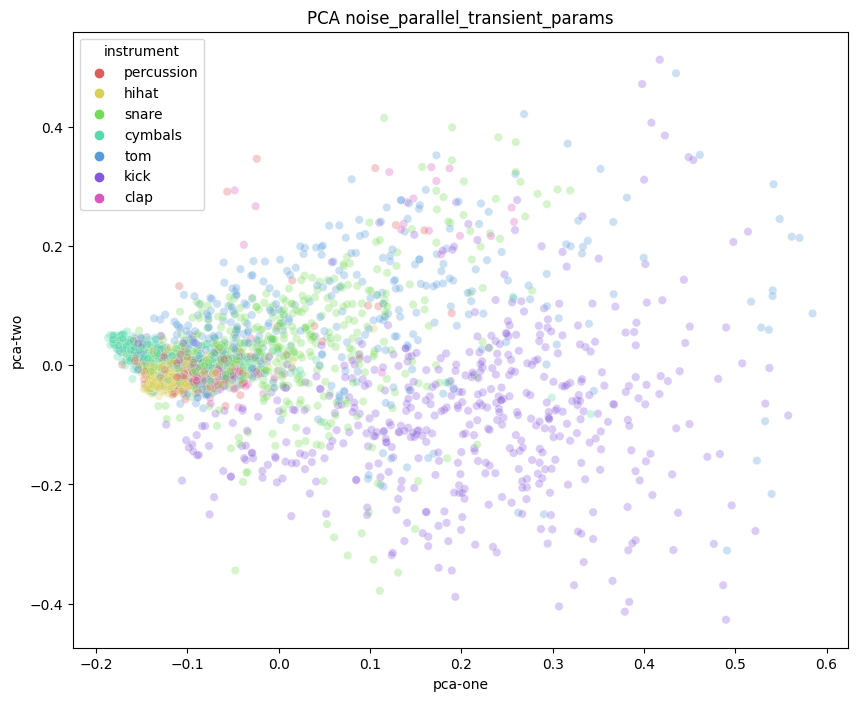

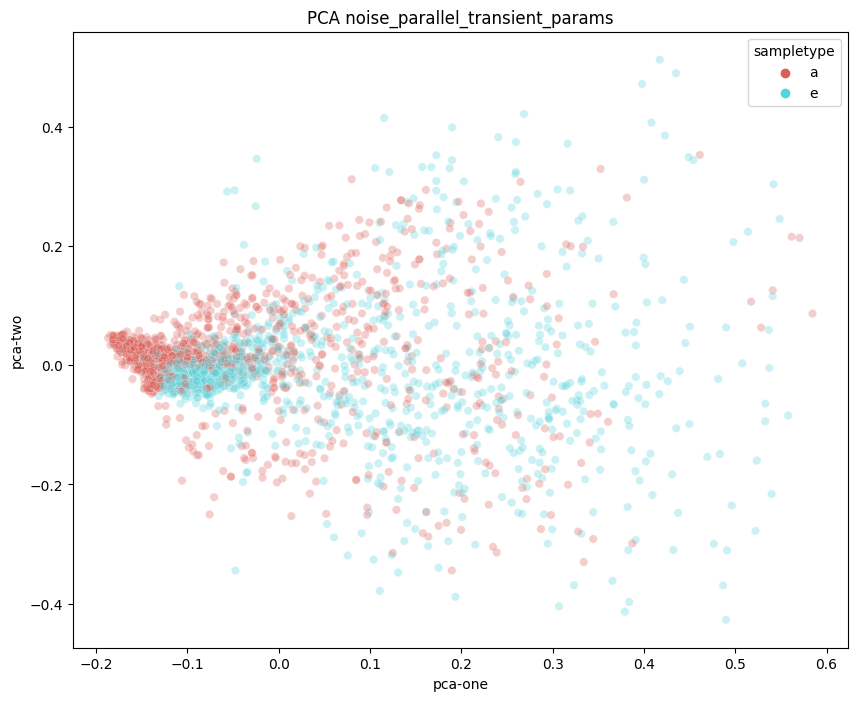

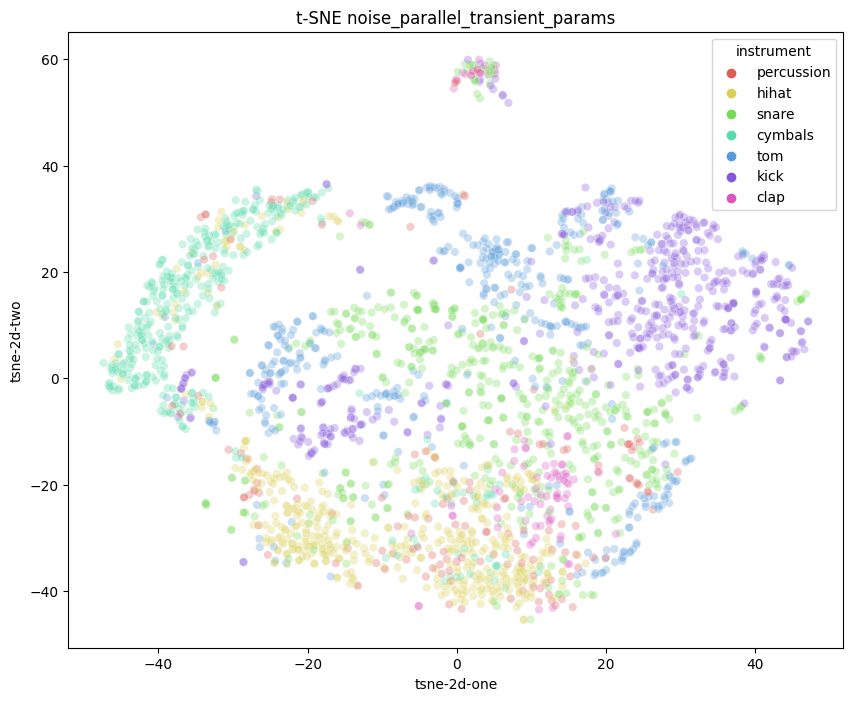

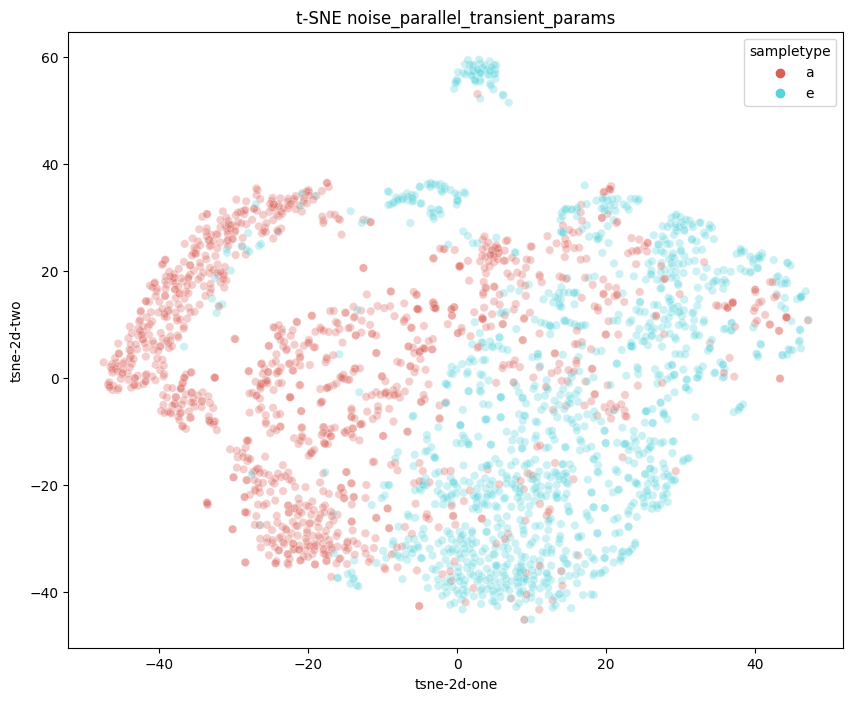

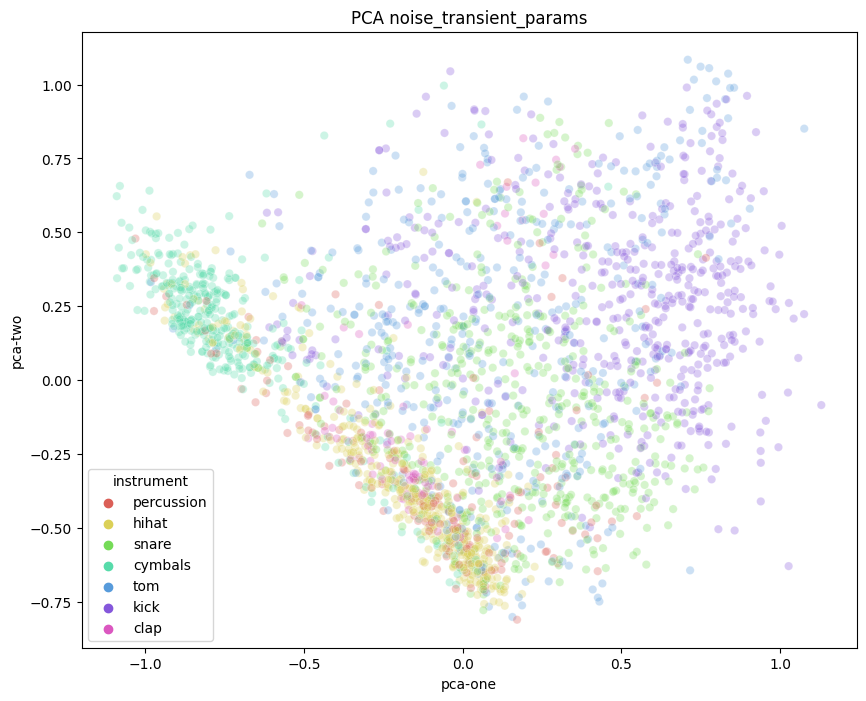

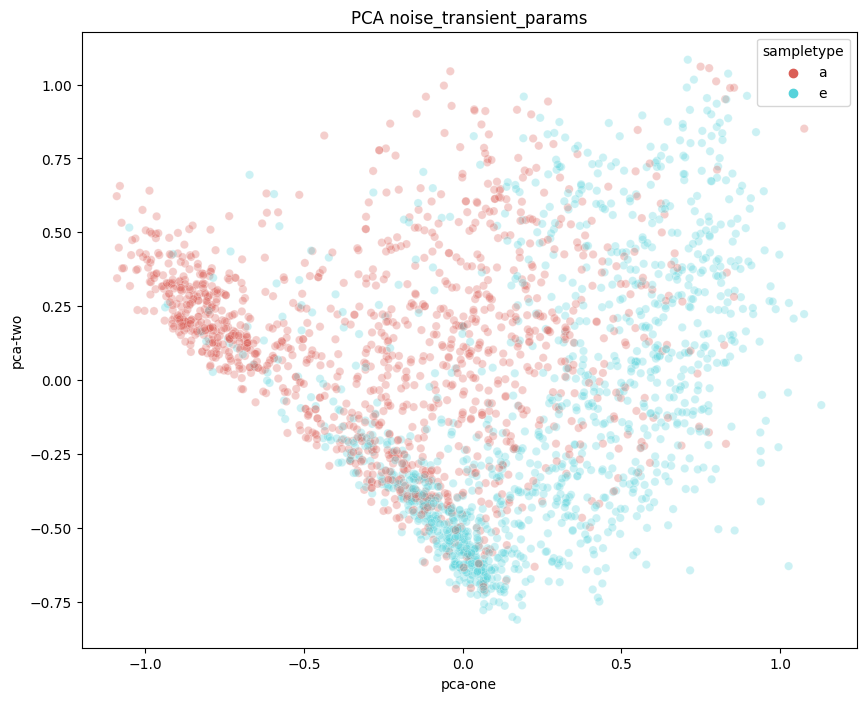

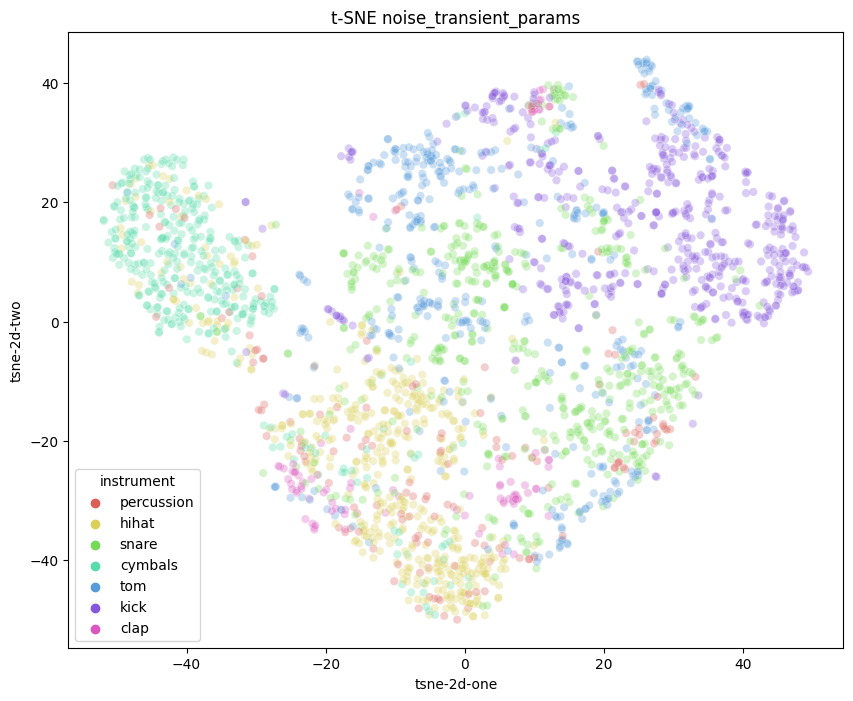

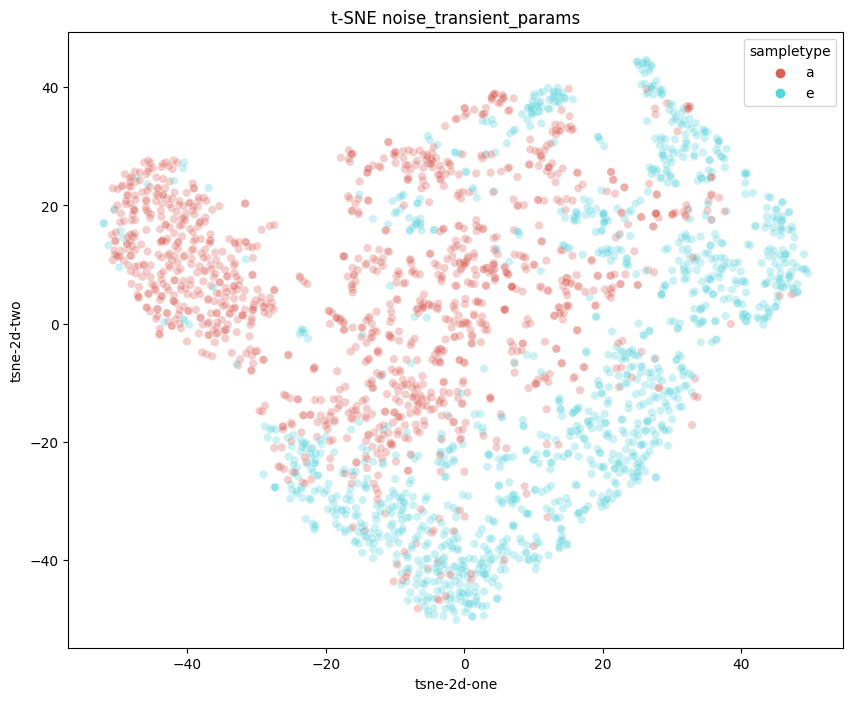

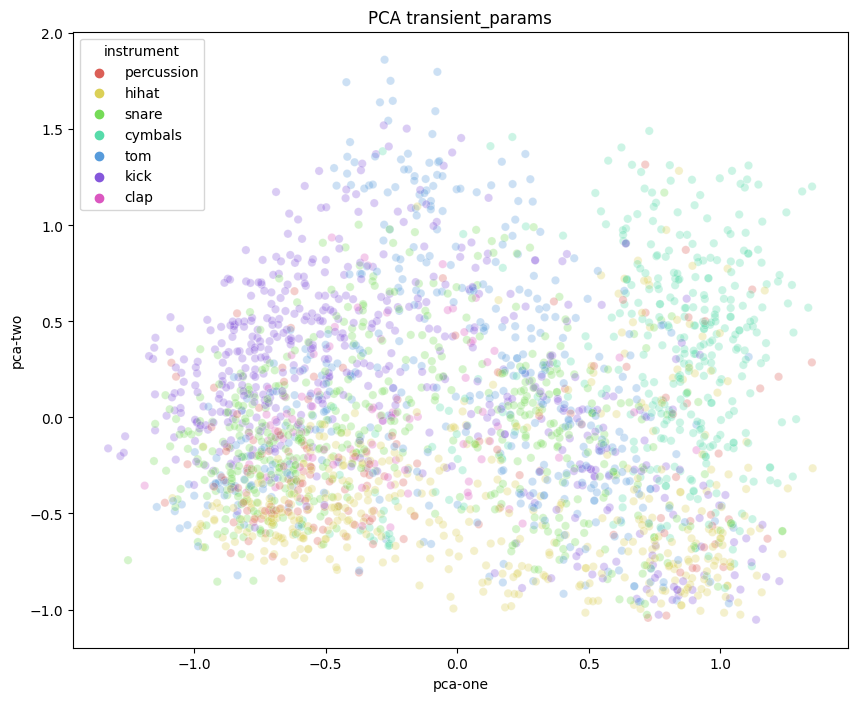

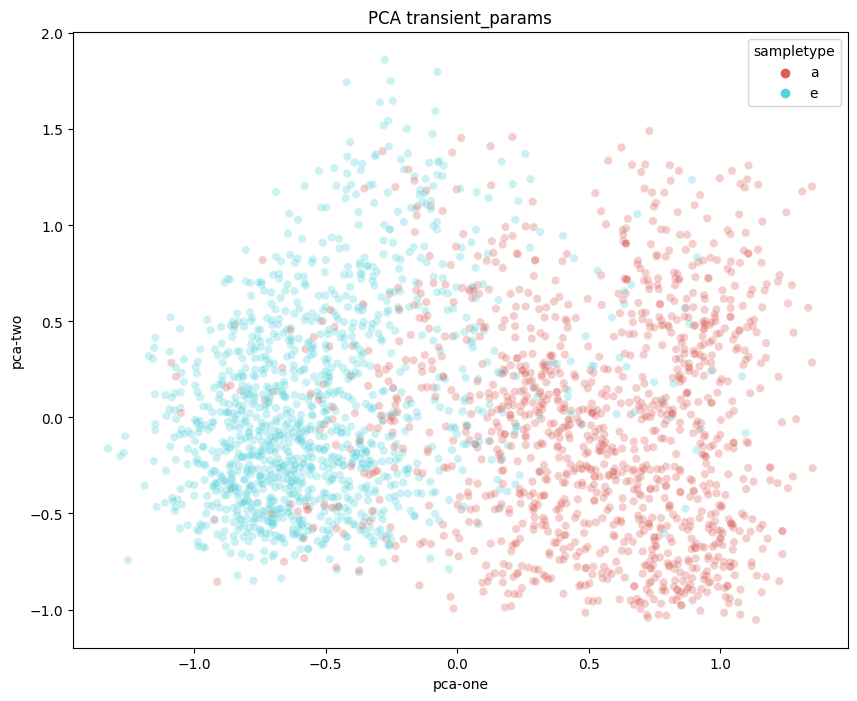

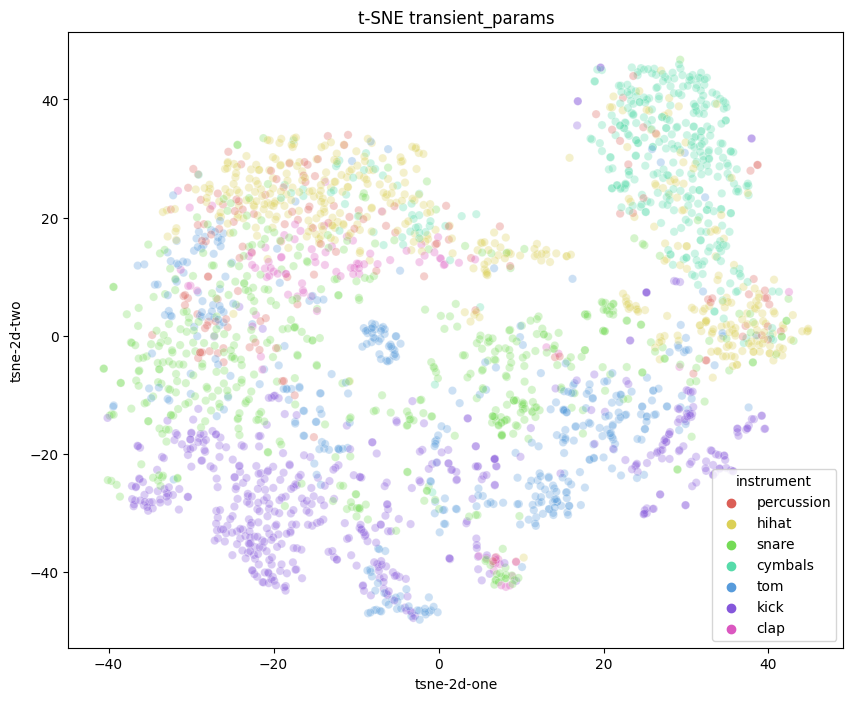

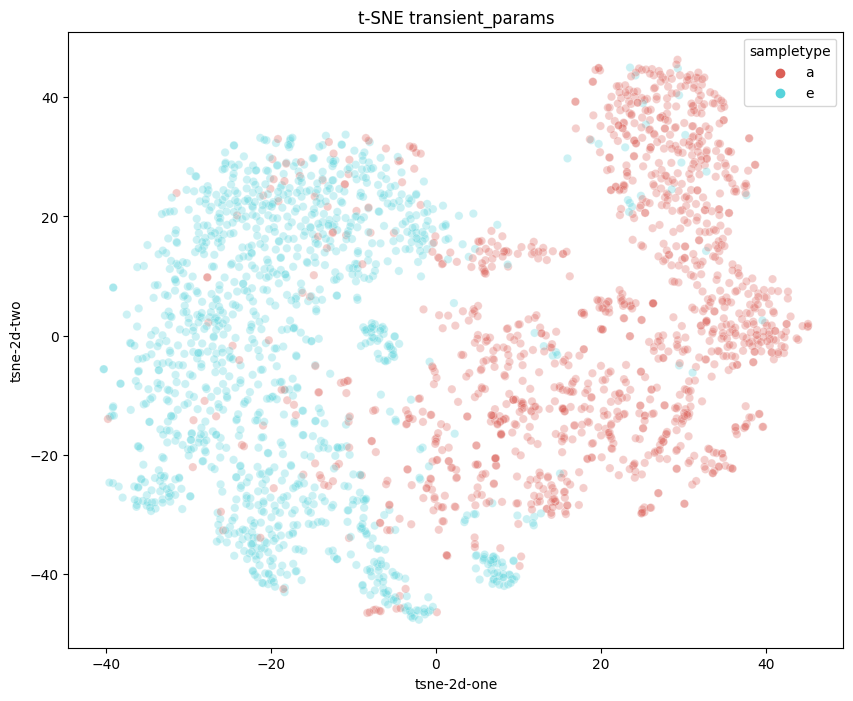

In [ ]:

transiefor model in feature_results.keys():
  run_pca(feature_results[model],feature_cols,permutation,"instrument",
          instruments,title=f'PCA {model}',legendtitle='Instrument Type',
          save_filename=f'{model}_pca_instr.png')
  
  run_pca(feature_results[model],feature_cols,permutation,"sampletype",
          sampletype,title=f'PCA {model}',legendtitle='Sample Type',
          save_filename=f'{model}_pca_stype.png')
  
  run_tsne(feature_results[model],feature_cols,permutation,'instrument',
           instruments,title=f't-SNE {model}',legendtitle="Instrument Type",
           save_filename=f'{model}_tsne_instr.png')
  
  run_tsne(feature_results[model],feature_cols,permutation,'sampletype',
           sampletype,title=f't-SNE {model}',legendtitle="Sample Type",
           save_filename=f'{model}_tsne_stype.png')

In [ ]:
!tar -cvf plots.tar *.png
!rm -rf ./features
!rm -rf *.png

all_parallel_pca_instr.png
all_parallel_pca_stype.png
all_parallel_tsne_instr.png
all_parallel_tsne_stype.png
noise_parallel_transient_params_pca_instr.png
noise_parallel_transient_params_pca_stype.png
noise_parallel_transient_params_tsne_instr.png
noise_parallel_transient_params_tsne_stype.png
noise_transient_params_pca_instr.png
noise_transient_params_pca_stype.png
noise_transient_params_tsne_instr.png
noise_transient_params_tsne_stype.png
transient_params_pca_instr.png
transient_params_pca_stype.png
transient_params_tsne_instr.png
transient_params_tsne_stype.png


Explained variation per principal component: [0.36291918 0.11819628 0.08328753]


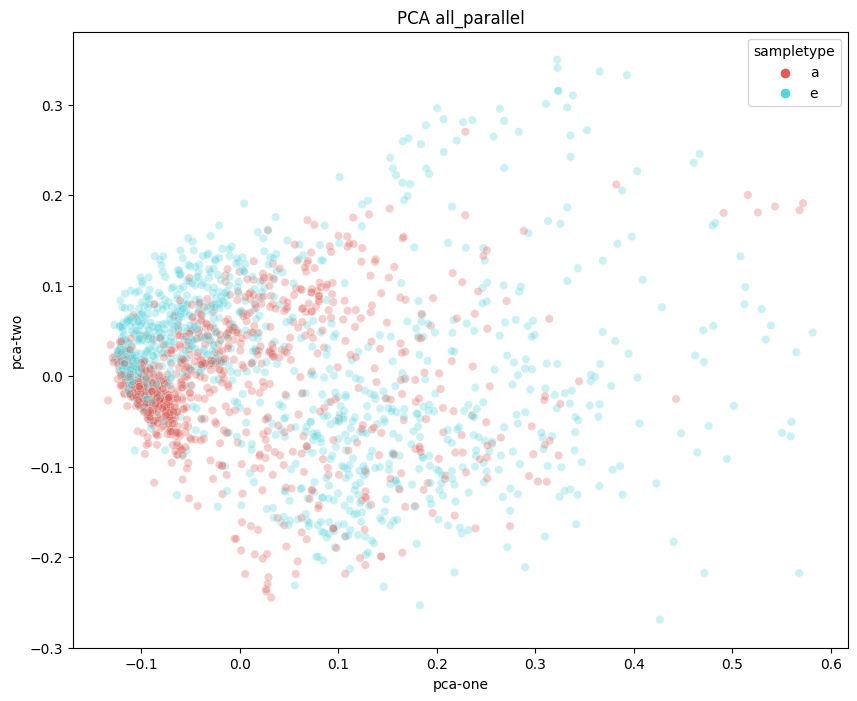

In [ ]:
model = 'all_parallel'
run_pca(feature_results[model],feature_cols,permutation,label_axis="sampletype",
        label_list = sampletype,title=f'PCA {model}',legendtitle='Sample Type')

Explained variation per principal component: [0.36291912 0.11819636 0.08328761]


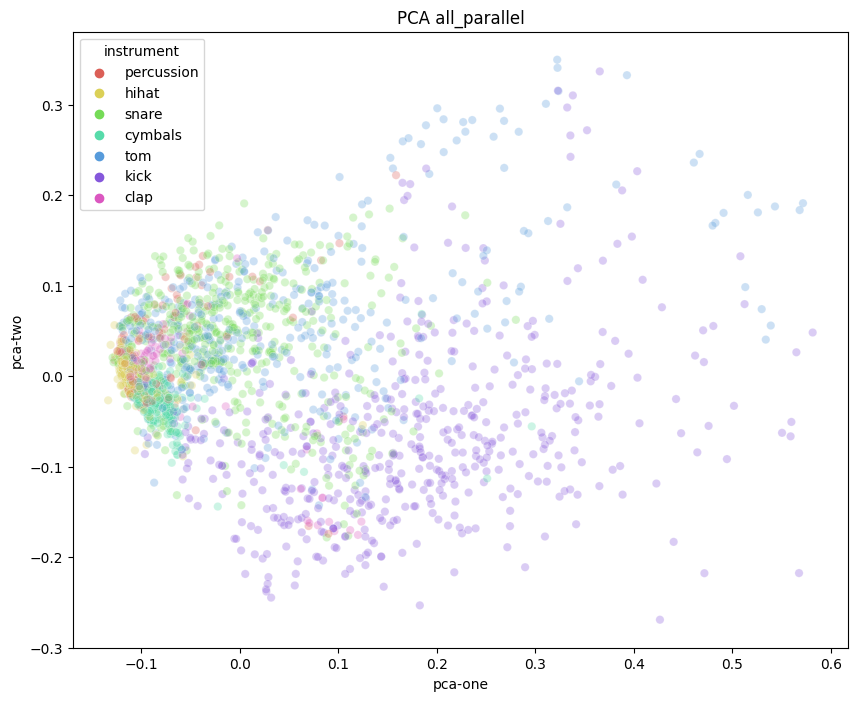

In [ ]:
model = 'all_parallel'
run_pca(feature_results[model],feature_cols,permutation,label_axis="instrument",
        label_list = instruments,title=f'PCA {model}',legendtitle='Instrument Type')

Explained variation per principal component: [0.3629192  0.11819639 0.08328761]


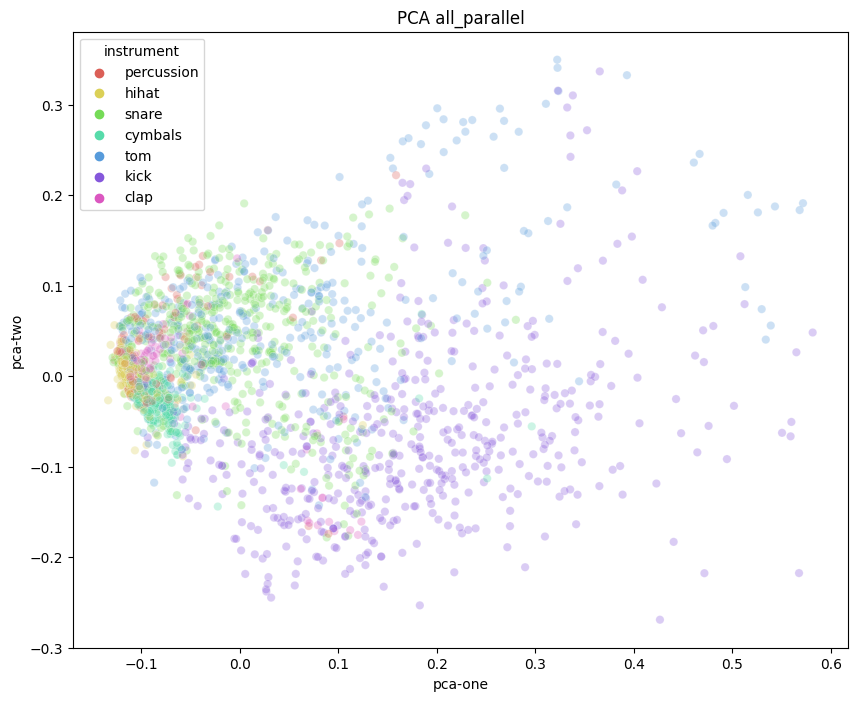

In [ ]:
model = 'all_parallel'
run_pca(feature_results[model],feature_cols,permutation,label_axis="instrument",
        label_list = instruments,title=f'PCA {model}',legendtitle='Instrument Type')